In [1]:
%matplotlib inline
from pandas_datareader import data
import pandas as pd
from SALib.sample import latin
from functions.stylizedfacts import *
from functions.evolutionaryalgo import *
from functions.helpers import hurst, organise_data, div_by_hundred, discounted_value_cash_flow, find_horizon, calculate_npv
import matplotlib.pyplot as plt
import quandl
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Evolutionary algorithm to calibrate model

## 1 Calculate fundamental value using shiller data

In [3]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]

In [4]:
# later plot discount rate if markets are efficient
schul_data = pd.read_excel('http://www.macrohistory.net/JST/JSTmoneyR3.xlsx', sheetname='Data')[['year', 'country', 'stir']]
schul_data = schul_data.loc[(schul_data.country == 'USA')]
schul_data = schul_data.iloc[1:]
schul_data = schul_data.set_index('year')

In [5]:
def div_by_hundred(x):
    return x / 100.0

In [6]:
# extend make list 
schul_data['stir']

short_term_int = []
counter = -1
for idx in range(len(shiller_data)):
    if idx % 12 == 0:
        counter += 1
    try:
        short_term_int.append(schul_data['stir'].iloc[counter])
    except:
        pass
#short_term_int

In [7]:
discount_rates = np.array(short_term_int) + 5.2 # TODO correct for inflation?
discount_rates = pd.Series(discount_rates).apply(div_by_hundred)
#discount_rates

In [8]:
long_int = shiller_data['Rate GS10'].apply(div_by_hundred)

In [9]:
def discounted_value_cash_flow(cash_flow, periods_ahead, disc_rate):
    return cash_flow / (1 + disc_rate)**periods_ahead

In [10]:
current_index = 0
final_index = len(shiller_data['Dividend'])
discounted_cash_flows = shiller_data['Dividend'] / ((1 + long_int)**range(current_index, final_index))

In [11]:
sum(discounted_cash_flows)

121.30106833314957

In [12]:
# at what period can the discounted_cash flows be cut off
# find index at which:
def find_horizon(dcfs):
    for idx, cash_flow in enumerate(dcfs):
        if cash_flow < 0.01:
            return idx
    return False

In [13]:
def calculate_npv(dividends, discount_rates):
    """Calculates the current NPV of a stream of dividends """
    current_index = 0
    final_index = len(dividends)
    discounted_cash_flows = dividends / ((1 + discount_rates)**range(current_index, final_index))
    if find_horizon(discounted_cash_flows):
        return sum(discounted_cash_flows[:find_horizon(discounted_cash_flows)])
    else: 
        return np.nan

In [14]:
len(shiller_data['Dividend'])

1770

In [15]:
calculate_npv(shiller_data['Dividend'][:-18], discount_rates)

50.979017660094733

In [20]:
find_horizon(discounted_cash_flows)

191

In [17]:
fundamental_values = []
for idx, cf in enumerate(shiller_data['Dividend'][:-18]):
    next_period_divs = shiller_data['Dividend'][idx+1:]
    next_period_ints = discount_rates[idx+1]
    npv = calculate_npv(next_period_divs, next_period_ints)
    if not np.isnan(npv):
        fundamental_values.append(npv)
    else:
        break

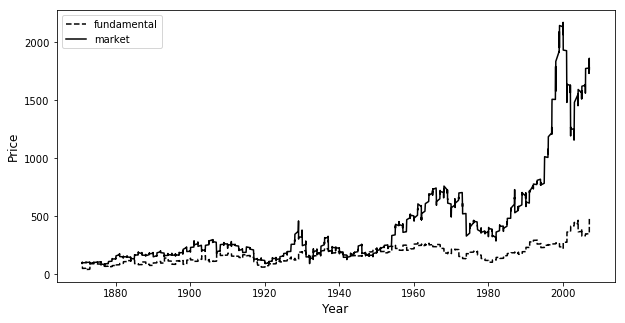

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(shiller_data['Date'][:len(fundamental_values)], fundamental_values, 'k--', label='fundamental')
ax1.plot(shiller_data['Date'][:len(fundamental_values)], shiller_data['Price'][:len(fundamental_values)], 'k-', label='market')

ax1.set_ylabel('Price', fontsize='12')
ax1.set_xlabel('Year', fontsize='12')

ax1.legend()

fig.savefig('fundamental_value_USA.png')

# Stylized fact of disconnect to fundamentals:

In [21]:
# calculate co-integration of price and fundamentals 
model = sm.OLS(fundamental_values, shiller_data['Price'][:len(fundamental_values)])
res = model.fit()
residuals = res.resid

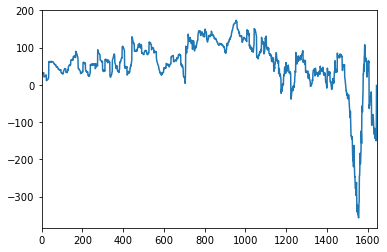

In [22]:
residuals.plot()

In [23]:
cadf = ts.adfuller(residuals) # can be rejected at 5%
print('ADF test statistic ', cadf[0])
print('ADF critical values', cadf[4])

ADF test statistic  -3.39593294701
ADF critical values {'5%': -2.8633268625511046, '10%': -2.5677212878453477, '1%': -3.4343955209592241}


# 

In [2]:
start_date = '1960-01-01'
end_date = '2016-8-31'
window = 320

spy_real_price = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_real_price = spy_real_price.rename(columns={"Value": "price"})

spy_returns = spy_real_price.pct_change()[1:]

spy_dividends = quandl.get("MULTPL/SP500_DIV_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_dividends = spy_dividends.rename(columns={"Value": "dividends"})
spy_dividends.index = spy_dividends.index + pd.offsets.MonthBegin(1)
spy_all = spy_dividends.join(spy_real_price)

spy_t_bill = quandl.get("FRED/INTGSTUSM193N", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_t_bill = spy_t_bill.rename(columns={"Value": "dividends"})

spy_all['t_bill_int'] = spy_t_bill / 100

spy_all['div_growth'] = spy_all['dividends'].pct_change()
spy_all['av_div_growth'] = spy_all['div_growth'].rolling(window=window,center=False).mean()
spy_all['yield'] = spy_all['dividends'].iloc[1:] / spy_all['price'].iloc[:-1]
spy_all['ml_discount'] = [0.052 for x in range(len(spy_all))]
spy_all['fixed_yield'] = spy_all['t_bill_int'] + spy_all['ml_discount']

spy_all = spy_all.iloc[-window:-1]

spy_all['fundamental'] = ((1 + spy_all['av_div_growth']) / (spy_all['fixed_yield'] - spy_all['av_div_growth'])) * spy_all['dividends']
spy_all['dev_fundamental'] = (spy_all['price'] - spy_all['fundamental']) / spy_all['fundamental']

## 2 Extract stylized facts

Perhaps try to use the ADF of residuals between fundamentals and prices as a stylized fact. Also simulate longer so to show that there either is, or is no mean-reversion. 

In [5]:
spy_autocorrelation = autocorrelation_returns(spy_returns['price'], 25)
spy_kurtosis = kurtosis(spy_returns['price'])
spy_autocorrelation_abs = autocorrelation_abs_returns(spy_returns['price'], 25)
spy_hurst = hurst(spy_all['price'])

#spy_dev_fund_hurst = hurst(spy_all['dev_fundamental'].iloc[:-1])
av_def_fund = abs(np.mean(spy_all['dev_fundamental']))
stylized_facts_spy = [spy_kurtosis, spy_autocorrelation_abs, spy_hurst, av_def_fund]

stylized_facts_spy = pd.DataFrame(stylized_facts_spy, columns=['S&P500'], 
             index=['kurtosis', 'autocorrelation_abs', 'hurst', 'av_dev_from_fund']).to_dict()['S&P500']

In [6]:
spy_all[['price', 'dividends', 't_bill_int']].describe()

,price,dividends,t_bill_int
count,319.000000,319.000000,319.000000
mean,1097.090502,27.415517,0.028564
std,479.143226,6.537052,0.022908
min,307.120000,21.650000,0.000100
25%,688.170000,22.430000,0.001850
50%,1133.360000,24.830000,0.030500
75%,1378.400000,30.750000,0.049600
max,2170.950000,46.680000,0.078700


In [8]:
stylized_facts_spy

{'autocorrelation_abs': 0.049914003700974562,
 'av_dev_from_fund': 1.9880606822750695,
 'hurst': 0.41423988932290928,
 'kurtosis': 3.0676490833426238}

319

## Obtain fixed parameters from data

In [54]:
start_fundamental_value = int(spy_all['fundamental'].mean())
std_fundamental_value = spy_all['fundamental'].std()
burn_in_period = 100 
ticks = len(spy_all['fundamental']) + burn_in_period

## 3 Define parameter space bounds 

Table 1 shows the parameter bounds, free parameters are **bold**. 

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| ticks       | 2000, 2000, 0   |
| fundamental_value       | 100, 100, 0      |
| **n_traders**       | 100, 5000, 25      |
| **trader_sample_size**       | 1, 100, 10      |
| **std_fundamental**       | 0.01, 0.2 , 0.01     |
| **std_noise**       | 0.01, 0.35, 0.01      |
| **std_vol**       | 1, 50, 1      |
| **max_order_expiration_ticks**       | 5, 200, 5       |
| **w_fundamentalists**       | 0.0, 100.0., 1.0      |
| **w_momentum**       | 0.0, 100.0, 1.0      |
| **w_random**       | 0.0, 100.0, 1.0      |
| **w_mean_reversion**       | 0.0, 100.0, 1.0       |
| **spread_max**       | 0.01, 0.15, 0.01       |
| **horizon_min**       | 1, 8, 1      |
| **horizon_max**       | 9, 30, 1      |
*Table 1 Parameter bounds*

In [9]:
problem = {
  'num_vars': 11,
  'names': ['trader_sample_size', 'std_noise', 
            'std_vol', 'max_order_expiration_ticks', 'w_fundamentalists', 'w_momentum',
           'w_random', 'w_mean_reversion', 'spread_max',
           'horizon_min', 'horizon_max'],
  'bounds': [[1, 30], [0.05, 0.30], 
             [1, 20], [10, 100], [0.0, 100.0], [0.0, 100.0], 
             [0.0, 100.0], [0.0, 100.0], [0.01, 0.15], # change mean reversion to 100.0
             [1, 8], [9, 30]]
}

In [26]:
problem_no_mean_reversion = {
  'num_vars': 10,
  'names': ['trader_sample_size', 'std_noise', 
            'std_vol', 'max_order_expiration_ticks', 'w_fundamentalists', 'w_momentum',
           'w_random', 'spread_max',
           'horizon_min', 'horizon_max'],
  'bounds': [[1, 30], [0.05, 0.30], 
             [1, 20], [10, 100], [0.0, 100.0], [0.0, 100.0], 
             [0.0, 100.0], [0.01, 0.15],
             [1, 8], [9, 30]]
}

## 4 Sample the parameter space using a latin hypercube

In [19]:
population_size = 500

In [20]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()

In [27]:
hyper_cube_no_mean_reversion = latin.sample(problem=problem_no_mean_reversion, N=population_size)
hyper_cube_no_mean_reversion = hyper_cube_no_mean_reversion.tolist()

In [21]:
len(latin_hyper_cube)

500

In [23]:
# transform some of the parameters to integer
for idx, parameters in enumerate(latin_hyper_cube):
    # ints: 0, 2, 3, 9, 10
    latin_hyper_cube[idx][0] = int(latin_hyper_cube[idx][0])
    latin_hyper_cube[idx][2] = int(latin_hyper_cube[idx][2])
    latin_hyper_cube[idx][3] = int(latin_hyper_cube[idx][3])
    latin_hyper_cube[idx][9] = int(latin_hyper_cube[idx][9])
    latin_hyper_cube[idx][10] = int(latin_hyper_cube[idx][10])

In [28]:
# transform some of the parameters to integer
for idx, parameters in enumerate(hyper_cube_no_mean_reversion):
    # ints: 0, 2, 3, 9, 10
    hyper_cube_no_mean_reversion[idx][0] = int(hyper_cube_no_mean_reversion[idx][0])
    hyper_cube_no_mean_reversion[idx][2] = int(hyper_cube_no_mean_reversion[idx][2])
    hyper_cube_no_mean_reversion[idx][3] = int(hyper_cube_no_mean_reversion[idx][3])
    hyper_cube_no_mean_reversion[idx][8] = int(hyper_cube_no_mean_reversion[idx][8])
    hyper_cube_no_mean_reversion[idx][9] = int(hyper_cube_no_mean_reversion[idx][9])

## 5 Run evolutionary algorithm

In [31]:
# create initial population model
population = []
for parameters in latin_hyper_cube:
    pars = {}
    for key, value in zip(problem['names'], parameters):
        pars[key] = value
    population.append(Individual(pars, [], np.inf))
all_populations = [population]
av_pop_fitness = []

In [32]:
# create initial population model no-mean reversion
population_no_mean_reversion = []
for parameters in hyper_cube_no_mean_reversion:
    pars = {}
    for key, value in zip(problem_no_mean_reversion['names'], parameters):
        pars[key] = value
    population_no_mean_reversion.append(Individual(pars, [], np.inf))
all_populations_no_mean_reversion = [population_no_mean_reversion]
av_pop_fitness_no_mean_reversion = []

In [51]:
fixed_parameters = {"ticks": 1000, "fundamental_value": start_fundamental_value, "w_buy_hold": 0.0, 
                    'n_traders': 1000, 'std_fundamental': std_fundamental_value}
fixed_parameters_no_mean_reversion = {"ticks": 1000, "fundamental_value": start_fundamental_value, 
                                      "w_buy_hold": 0.0, "w_mean_reversion": 0.0,
                                      'n_traders': 1000, 'std_fundamental': std_fundamental_value}
iterations = 50
NRUNS = 16

In [21]:
for generation in range(iterations):
    # simulate every population
    simulated_population, fitness = simulate_population(all_populations[generation], NRUNS, fixed_parameters, stylized_facts_spy)
    # record population fitness
    av_pop_fitness.append(fitness)
    print('generation: ', generation, 'fitness: ', fitness)
    # add a new, evolved population to the list of populations
    all_populations.append(evolve_population(simulated_population, fittest_to_retain=0.3, random_to_retain=0.2, 
                                             parents_to_mutate=0.3, parameters_to_mutate=0.1, problem=problem))

generation:  0 fitness:  38.0281757362
generation:  1 fitness:  5.39541829697
generation:  2 fitness:  2.90862383292
generation:  3 fitness:  3.06989756835
generation:  4 fitness:  2.1161133293
generation:  5 fitness:  4.72723926808
generation:  6 fitness:  2.67748232561
generation:  7 fitness:  2.28953615834
generation:  8 fitness:  2.19496590594
generation:  9 fitness:  2.60115492056
generation:  10 fitness:  2.28633189556
generation:  11 fitness:  2.05264370721
generation:  12 fitness:  1.97836905165
generation:  13 fitness:  1.92253901676
generation:  14 fitness:  1.14915113933
generation:  15 fitness:  1.13743685676
generation:  16 fitness:  1.42970115564
generation:  17 fitness:  1.16514009334
generation:  18 fitness:  1.21292505619
generation:  19 fitness:  2.83046111955
generation:  20 fitness:  2.1459643622
generation:  21 fitness:  2.03816421661
generation:  22 fitness:  2.04583812554
generation:  23 fitness:  2.03701258273
generation:  24 fitness:  2.04270356085
generation: 

KeyboardInterrupt: 

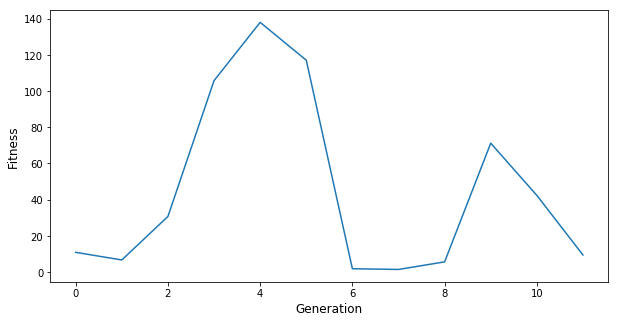

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(av_pop_fitness)), av_pop_fitness)
ax1.set_ylabel('Fitness', fontsize='12')
ax1.set_xlabel('Generation', fontsize='12')

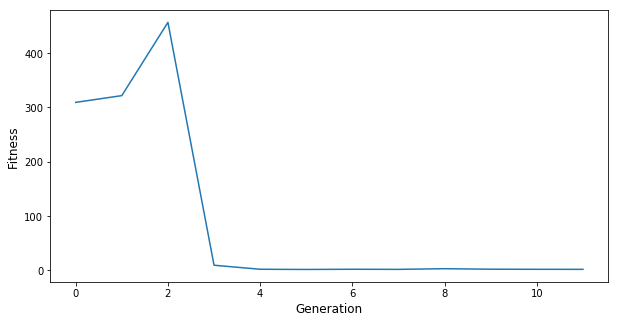

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(av_pop_fitness)), av_pop_fitness)
ax1.set_ylabel('Fitness', fontsize='12')
ax1.set_xlabel('Generation', fontsize='12')

## Extract parameter values:

### Best parameters

In [25]:
parameters = all_populations[15][0].parameters.copy()
params = fixed_parameters.copy()
params.update(parameters)
params

{'fundamental_value': 100,
 'horizon_max': 22,
 'horizon_min': 2,
 'max_order_expiration_ticks': 24,
 'n_traders': 1981,
 'spread_max': 0.1034423464335639,
 'std_fundamental': 0.10754244839080045,
 'std_noise': 0.20680836615919262,
 'std_vol': 11,
 'ticks': 1000,
 'trader_sample_size': 21,
 'w_buy_hold': 0.0,
 'w_fundamentalists': 59.96213213200949,
 'w_mean_reversion': 72.9727690079459,
 'w_momentum': 94.61305458063075,
 'w_random': 44.351363543793354}

### Best stylized facts compared to actual stylized facts

In [15]:
print('simulation:')
print(all_populations[-1][0].stylized_facts)
print('s&p500:')
print(stylized_facts_spy)

simulation:
{'hurst': 0.41357911669500397, 'hurst_dev_from_fund': 0.357733598208332, 'autocorrelation_abs': 0.037062487136276481, 'kurtosis': 2.7307393691887967, 'autocorrelation': inf}
s&p500:
{'hurst': 0.41423988932290928, 'hurst_dev_from_fund': 0.40316509821293978, 'autocorrelation_abs': 0.049914003700974562, 'kurtosis': 3.0676490833426238}
